<a href="https://colab.research.google.com/github/rafaela00castro/pytorch-hands-on/blob/master/mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on PyTorch



> ### Machine Learning course / PPCIC @ CEFET-RJ 
> Rafaela Castro  (<rafaela.nascimento@eic.cefet-rj.br>)

---


## Image classification with Convolutional Neural Networks (CNN)

We will train a CNN to classify images from MNIST dataset, which is a hand-written digit dataset. The images are of size 1x28x28, i.e. a 1-channel grayscale image.

First of all, let's check the configuration of Colab's processor.

In [1]:
!lscpu # cpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:            3
CPU MHz:             2000.192
BogoMIPS:            4000.38
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            39424K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_si

In [2]:
!nvidia-smi # gpu

Fri Oct 16 01:08:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install Pytorch

Since January/19, Colab supports PyTorch natively. So, you do not need to run the code below.

`!pip install torch torchvision`

### Import libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, DataLoader

from torchvision import datasets, transforms
from torchvision.utils import make_grid

%matplotlib inline

### Device configuration

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Define the seed

In [5]:
seed = 15
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

### Load the MNIST dataset

Specifically for computer vision, PyTorch has a package called torchvision, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.

The output of torchvision datasets are [PIL image](https://en.wikipedia.org/wiki/Python_Imaging_Library) images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [6]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                              ])

**Training dataset**: The model learns from this dataset's examples. It fits a parameter to a classifier.

**Validation dataset**: The examples in the validation dataset are used to tune the hyperparameters, such as learning rate and epochs. The aim of creating a validation set is to avoid large overfitting of the model.

**Test dataset**: This dataset test the final evaluation of the model, measuring how well it has learned and predicted the desired output. It contains unseen data.

In [7]:
batch_size = 20
num_workers = 4

full_train_dataset = datasets.MNIST(root='./data', train=True,
                            download=True, transform=transform)

test_data = datasets.MNIST(root='./data', train=False,
                           download=True, transform=transform)

train_data, val_data = random_split(full_train_dataset, [50000, 10000])


train_loader = DataLoader(train_data, batch_size=batch_size,
                          shuffle=True, num_workers=num_workers)

val_loader = DataLoader(val_data, batch_size=batch_size,
                          shuffle=False, num_workers=num_workers)

test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=num_workers)

print('Size of full training dataset: ', len(train_data))
print('Size of training dataset: ', len(train_data))
print('Size of valitation dataset: ', len(val_data))
print('Size of test dataset: ', len(test_data))

Size of full training dataset:  50000
Size of training dataset:  50000
Size of valitation dataset:  10000
Size of test dataset:  10000


#### Ways to load your data into Colab

If you have a dataset in CSV format, follow [this tutorial](https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92).

### Visualize some images

In [8]:
def imshow(img_tensor):
  """
  function to show an image
  """
  img_tensor = img_tensor / 2 + 0.5     # unnormalize
  img_numpy = img_tensor.numpy()        # from tensor to numpy
  plt.imshow(np.transpose(img_numpy, (1, 2, 0)))
  plt.show()

Get one batch of training images.

In [9]:
data_iter = iter(train_loader)
images, labels = data_iter.next()
print('(batch size, channels, height, width) ', images.shape)

(batch size, channels, height, width)  torch.Size([20, 1, 28, 28])


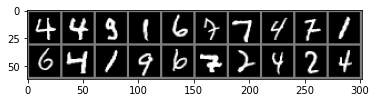

LABELS
 tensor([4, 4, 9, 1, 6, 7, 7, 4, 7, 1, 6, 4, 1, 9, 6, 7, 2, 4, 2, 4])


In [10]:
imshow(make_grid(images, nrow=10))
print('LABELS\n', labels)

### Define the CNN architecture






<img src="https://raw.githubusercontent.com/floydhub/mnist/master/images/mnist_convet.png">

How to calculate output size?

$outup\_size = \dfrac{(input\_size - kernel\_size +2 * padding)}{stride} + 1$

In [11]:
class ConvNet(nn.Module):
  
  def __init__(self):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=5, stride=2))

    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))

    self.fc1 = nn.Linear(20*4*4, 50)
    self.fc2 = nn.Linear(50, 10)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.view(-1, 20*4*4) # Flatten layer
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x

In [12]:
model = ConvNet().to(device)
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


### Define a Loss function and optimizer

The `nn.CrossEntropyLoss` criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

### Train the network

When we create a network with PyTorch, all of the parameters are initialized with   `requires_grad = True`. This means that when we calculate the loss and call `loss.backward()` , the gradients for the parameters are calculated. These gradients are used to update the weights with gradient descent.

In [14]:
%%time
num_epochs = 15
train_losses, val_losses = [], []

for epoch in range(1, num_epochs + 1):
    train_loss, val_loss = 0.0, 0.0

    model.train() # prepare model for training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # clear the gradients
        optimizer.zero_grad()
        # forward pass: compute predicted outputs
        output = model(inputs)
        # calculate the loss
        loss = criterion(output, labels)
        # backward pass: compute gradient
        loss.backward()
        # perform a optimization step (weight update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()
        
    model.eval() # validate the model
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            loss = criterion(output, labels)
            val_loss += loss.item()
    
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, val_loss))

Epoch: 1 	Training Loss: 2.276344 	Validation Loss: 2.237068
Epoch: 2 	Training Loss: 1.986001 	Validation Loss: 1.308965
Epoch: 3 	Training Loss: 0.784418 	Validation Loss: 0.360614
Epoch: 4 	Training Loss: 0.396263 	Validation Loss: 0.235817
Epoch: 5 	Training Loss: 0.295548 	Validation Loss: 0.186670
Epoch: 6 	Training Loss: 0.243429 	Validation Loss: 0.160827
Epoch: 7 	Training Loss: 0.213546 	Validation Loss: 0.144406
Epoch: 8 	Training Loss: 0.191204 	Validation Loss: 0.131526
Epoch: 9 	Training Loss: 0.173254 	Validation Loss: 0.121579
Epoch: 10 	Training Loss: 0.159897 	Validation Loss: 0.112813
Epoch: 11 	Training Loss: 0.149384 	Validation Loss: 0.106481
Epoch: 12 	Training Loss: 0.143020 	Validation Loss: 0.102328
Epoch: 13 	Training Loss: 0.132381 	Validation Loss: 0.097457
Epoch: 14 	Training Loss: 0.128288 	Validation Loss: 0.091993
Epoch: 15 	Training Loss: 0.122024 	Validation Loss: 0.088936
CPU times: user 2min 4s, sys: 16.6 s, total: 2min 21s
Wall time: 3min 53s


### Learning curve

Using a learning curve can help improve the performance of the model by tracking the loss of the training and validation dataset. We can get an idea of how well the model can generalize to new data. The example bellow shows that the model is overfitting.

<img src="https://www.baeldung.com/wp-content/uploads/sites/4/2020/07/overfitting_lc.png">

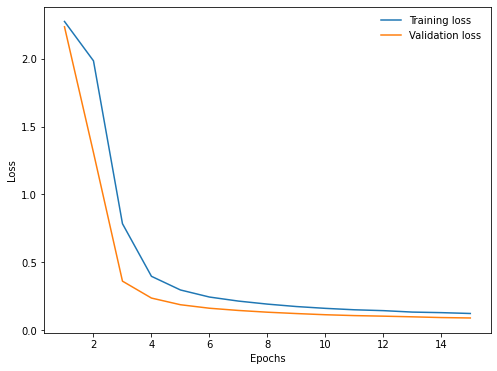

In [15]:
x_values = list(range(1,num_epochs+1))
plt.figure(figsize=(8., 6.))
plt.plot(x_values, train_losses, label='Training loss');
plt.plot(x_values, val_losses, label='Validation loss');
plt.xlabel("Epochs");
plt.ylabel("Loss");
plt.legend(frameon=False);

### Test the network on the test data

In [16]:
model.eval()  # prepare model for evaluation
with torch.no_grad():
    correct, total = 0.0, 0.0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Accuracy: {}%'.format(100 * correct / total))

Test Accuracy: 97.57%


#### Credits
This tutorial was adapted from [Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py), [Multi-Layer Perceptron, MNIST](https://github.com/Bjarten/deep-learning-ND/blob/master/convolutional-neural-networks/mnist-mlp/mnist_mlp_solution.ipynb) and [Image Classification with PyTorch](https://www.pluralsight.com/guides/image-classification-with-pytorch).